# Classification of User Knowledge Based on the Degree of Study Time for Goal Object Materials and the Degree of Repetition Number of User for Goal Object Materials
by Kyrstin Lavelle, Yushin Nam, Accita Ongko, Krianna Strowbridge

![](data/study_img.jpeg)
*Source: https://acmaps.info.yorku.ca/2014/12/studying-for-your-exams/*


## Introduction
In this project, we will be using the user knowledge database which was developed in 2013. The dataset shows the student's knowledge about the subject, electrical DC machines. The dataset is multivariant and has 403 observations. We will use this data to make predictions of a student's knowledge based on two predator variables. 
The question we want to answer is: 

* **What are the student's knowledge levels based on STG (the degree of study time for goal object materials) and SCG (the degree of repetition number of user for goal object materials)?**

We decided to choose STG and SCG as our 2 predictor variables as we believe that the degree of study time and the degree of repetition number are both very relevant and logically suitable to predict users' knowledge levels. 

The impact of this project can include several aspects:
* The accuracy of this project may determine its ability to make predictions on new, unseen data
* Provide educational insights on how students' knowledge levels may be influenced by their study time and repetition patterns to understand effective learning strategies
* Provide feedback to students regarding their study habits and potential impacts to their knowledge levels
* A successful KNN model can identify students at risk of low or very low knowledge levels early in their learning process, which allows for early risk mitigation and intervention, such as providing additional support and learning materials.
* The project can be a part of an interative process of continuous improvement in predicting more reliable and accurate predictions of user knowledge levels

## Methods

We will be using the K-nearest neighbor classification algorithm, with **STG** and **SCG** columns as our predictors and the **UNS** column as our response variable. Since the data is split already into a training set and a test set, we do not have to split it again. 

The first step is to choose the most suitable parameter K by splitting the training data into multiple different train/validation splits through cross-validation. We will be using 5-fold cross-validation to create 5 different validation sets. We will then create our data analysis workflow on each train/validation split, and evaluate the classifier’s validation accuracy across all the folds. We will pick the value of K that gives us the best accuracy with the help of tuned models and a plot that shows accuracy versus K. We will choose the K value with roughly optimal accuracy and stability (i.e. accuracy doesn’t change much when we decrease or increase the K value to a nearby one)

We will then incorporate this K value into our KNN model, which we will include into our final workflow along with a standardised recipe. We will use the predict function to make a prediction for the testing set

We will be visualising our prediction results as a scatter plot with “Study Time (STG)” on the x-axis and “Degree of Repetition (SCG)” on the y-axis. Each point will represent the predicted classification of the user knowledge, labeled different colors for different knowledge levels (i.e. very low, low, middle, and high).

We will also be evaluating the accuracy, precision, and recall of our classification model using the metrics function and the confusion matrix. To compute precision and recall, we will use the “very low” and “high” labels only (we will calculate precision and recall for both labels separately) to further evaluate the performance of the classification of the 2 contrasting predictions. 

## Preliminary Exploratory Data Analysis

In this section, we will:

* read the data and appropriately clean and wrangle the data
* summarise the training data 
* visualize the training data

In [25]:
library(tidyverse)
library(readxl)
library(tidymodels)

set.seed(1)

The following two cells shows reading the excel file in data folder within the current directory, as well as seleting the variable of interest and changing the names of variables so that it is convenient to see:
   * **STG** = study_time
   * **SCG** = repetition
   * **UNS** = knowledge_level
   
Also, by using "as_factor", we made knowledge_level as a factor type. Additionally, "very_low" class in knowledge_level is renamed as "Very Low". 

In [34]:
# we need to load data from the original source on the web, on our proposal our TA commented "didn't read the data from the web"

In [26]:
data_training = read_excel("data/user_knowledge.xls", sheet = "Training_Data", range = "A1:F259")
head(data_training)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


*Figure 0.1: Training dataset*

In [27]:
data_wrangled <- data_training |>
select(STG, SCG, UNS) |>
rename(study_time = STG, repetition = SCG, knowledge_level = UNS) |>
mutate(knowledge_level = as_factor(knowledge_level)) |> # knowledge_level is the response variable
mutate(knowledge_level = fct_recode(knowledge_level, "Very Low" = "very_low")) # rename "very_low" to "Very Low"

head(data_wrangled)

study_time,repetition,knowledge_level
<dbl>,<dbl>,<fct>
0.00,0.00,Very Low
0.08,0.08,High
0.06,0.06,Low
0.10,0.10,Middle
0.08,0.08,Low
0.09,0.15,Middle


*Figure 0.2: Training dataset wrangled*

The two cells below displays each mean/average values of study time and repetition, and the number of each category in knowledge level of users, respectively. 

In [28]:
data_wrangled |>
select(study_time, repetition) |>
map(mean, na.rm  = TRUE)

$study_time
[1] 0.3711473

$repetition
[1] 0.3556744

*Figure 0.3: Mean of Predictors*

In [29]:
data_wrangled |>
group_by(knowledge_level) |>
summarize(count = n()) |>
pivot_wider(names_from = knowledge_level, values_from = count)

Very Low,High,Low,Middle
<int>,<int>,<int>,<int>
24,63,83,88


*Figure 0.4: Total number of observations per category of User Knowledge*

In [35]:
# comment from TA on proposal: as you can see very low has 24 observations, what do you think is a procedure you should take for balancing this out?

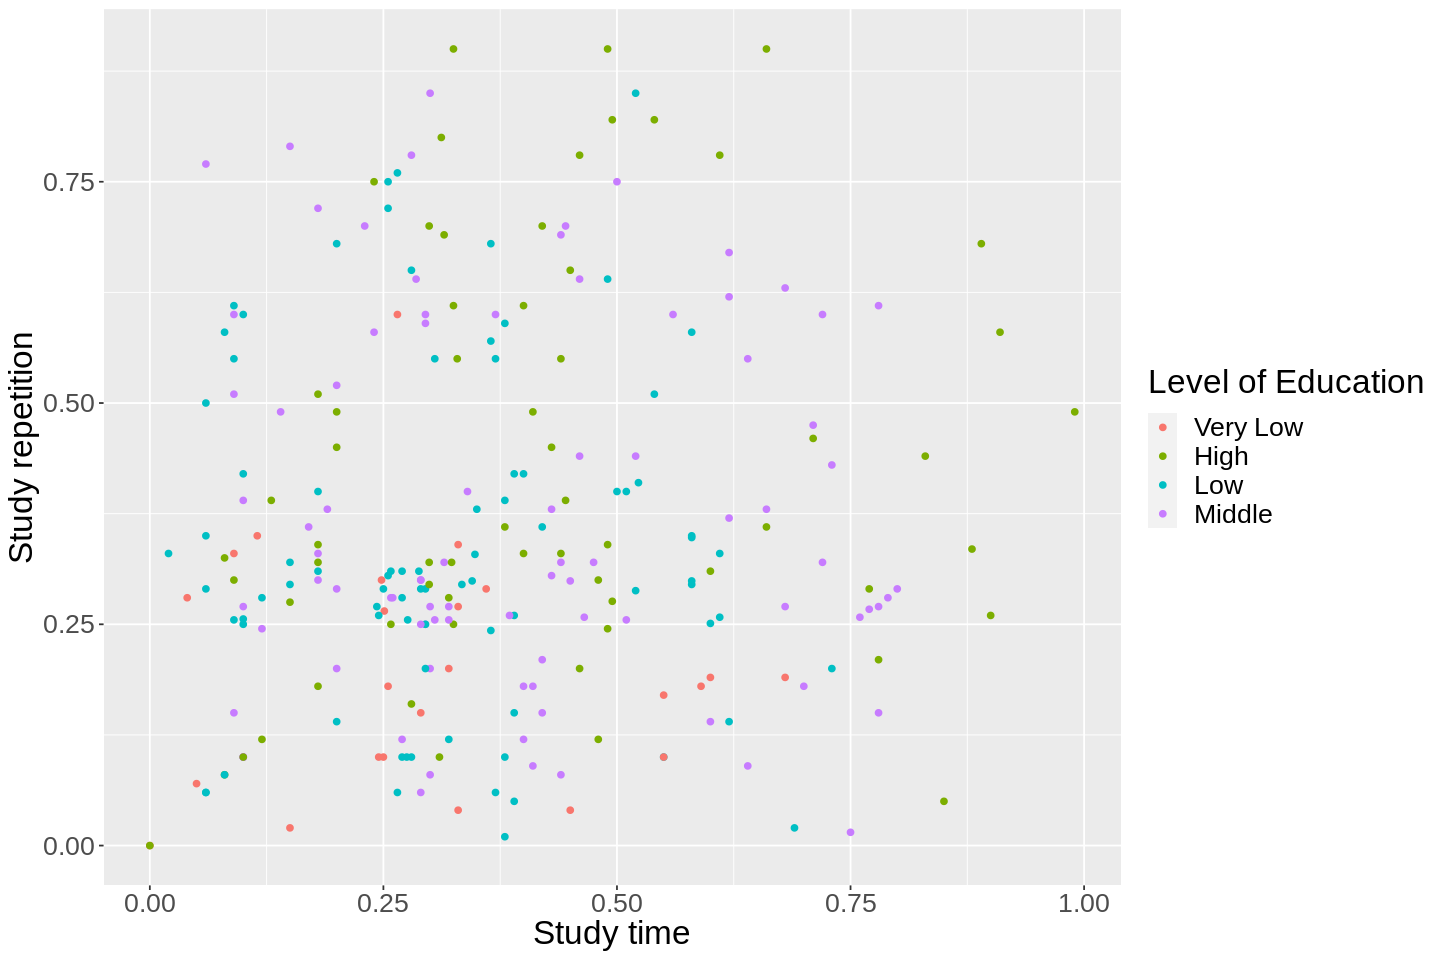

In [30]:
options(repr.plot.width = 12, repr.plot.height = 8)
stg_vs_scg_plot <- data_wrangled |>
ggplot(aes(x = study_time, y = repetition, color = knowledge_level)) +
geom_point() +
labs(x = "Study time", y = "Study repetition", color = "Level of Education") +
theme(text = element_text(size = 20))

stg_vs_scg_plot

*Figure 1: Study time vs. Study repeition plot*

## Methods & Results

We will now use $K$-nearest neighbours algorithm to classify test sets.

In [31]:
# Testing dataset
data_testing <- read_excel("data/user_knowledge.xls", sheet = "Test_Data", range = "A1:F259") |>
select(STG, SCG, UNS) |>
rename(study_time = STG, repetition = SCG, knowledge_level = UNS) |>
mutate(knowledge_level = as_factor(knowledge_level)) |>
mutate(knowledge_level = fct_recode(knowledge_level, "Very Low" = "very_low"))
head(data_testing)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `knowledge_level = fct_recode(knowledge_level, `Very Low` =
  "very_low")`.
Caused by warning:
! Unknown levels in `f`: very_low”


study_time,repetition,knowledge_level
<dbl>,<dbl>,<fct>
0.00,0.10,Very Low
0.05,0.05,Low
0.08,0.18,High
0.20,0.20,High
0.22,0.22,High
0.14,0.14,Low


*Figure 2: Testing dataset*

→ A | warning: No observations were detected in `truth` for level(s): 'Very Low'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x2





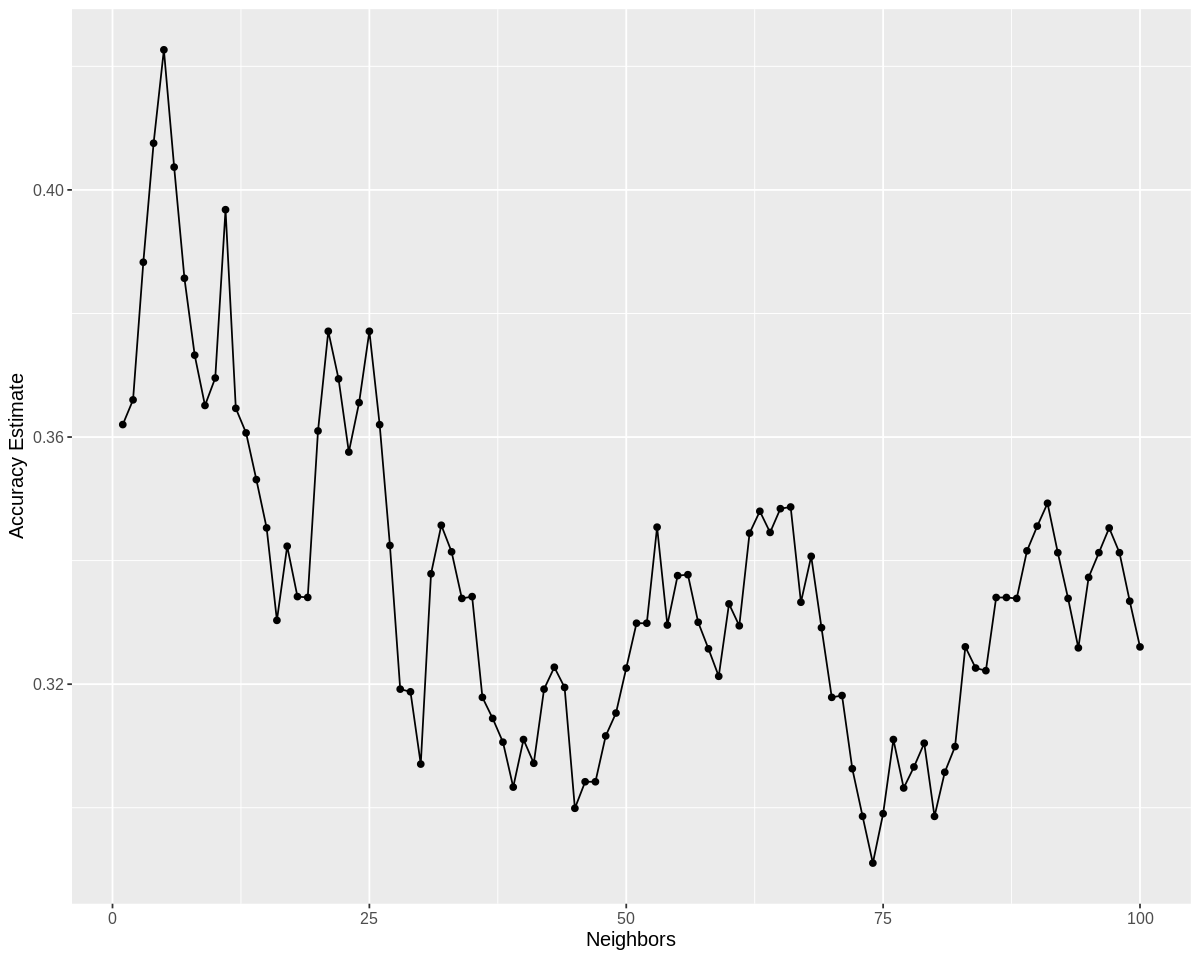

In [32]:
k_val <- tibble(neighbors = seq(from=1, to=100))

study_recipe <- recipe(knowledge_level ~ study_time + repetition, data = data_wrangled) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

study_vfold_10 <- vfold_cv(data_wrangled, v=10, strata=knowledge_level)

knn_results <- workflow() |>
add_recipe(study_recipe) |>
add_model(knn_spec) |>
tune_grid(resamples=study_vfold_10, grid=k_val) |>
collect_metrics()

accuracies <- knn_results |>
filter(.metric=="accuracy")

options(repr.plot.width=10, repr.plot.height=8)

accuracy_vs_k_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
geom_point() +
geom_line() +
labs(x="Neighbors", y="Accuracy Estimate")+
theme(text=element_text(size=12))

accuracy_vs_k_plot

*Figure 3: Plot of estimated accuracy versus the number of neighbors*

Based on the plot shown in Figure 3, we think that the most suitable K-value is K = 

## Discussion

In [33]:
#summarize what you found
#discuss whether this is what you expected to find?
#discuss what impact could such findings have?
#discuss what future questions could this lead to?

Future questions that can be investigated include:

* **What is the most optimal study time and degree of repetition for a high level of user knowledge?**
* **Are there individual differences in how study time and degree of repetition affect knowledge levels?**

## References

* Deeva, G., De Smedt, J., Saint-Pierre, C., Weber, R. W., & De Weerdt, J. (2022). Predicting student performance using sequence classification with time-based windows. Expert Systems With Applications, 209, 118182. https://doi.org/10.1016/j.eswa.2022.118182
* Dunlosky, J., Rawson, K. A., Marsh, E. J., Nathan, M. J., & Willingham, D. T. (2013). Improving students’ learning with effective learning techniques. Psychological Science in the Public Interest, 14(1), 4–58. https://doi.org/10.1177/1529100612453266 
* Bartoszewski, B. L., & Gurung, R. A. (2015). Comparing the relationship of learning techniques and exam score. Scholarship of Teaching and Learning in Psychology, 1(3), 219–228. https://doi.org/10.1037/stl0000036
* Agarwal, T. (2020, October 31). DC machine - construction, working, types, EMF Equation & Applications. ElProCus. https://www.elprocus.com/dc-machine-types-and-their-applications/#:~:text=A%20DC%20machine%20is%20an,that%20rotates%20the%20dc%20motor. 